Toy datasets idea taken from https://umap-learn.readthedocs.io/en/latest/auto_examples/plot_algorithm_comparison.html and added Diffusion map

In [ ]:
!pip install umap-learn
!pip install pyDiffMap

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn import datasets, decomposition, manifold, preprocessing
from colorsys import hsv_to_rgb

import umap
from pydiffmap import diffusion_map as dm 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:322: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_mat

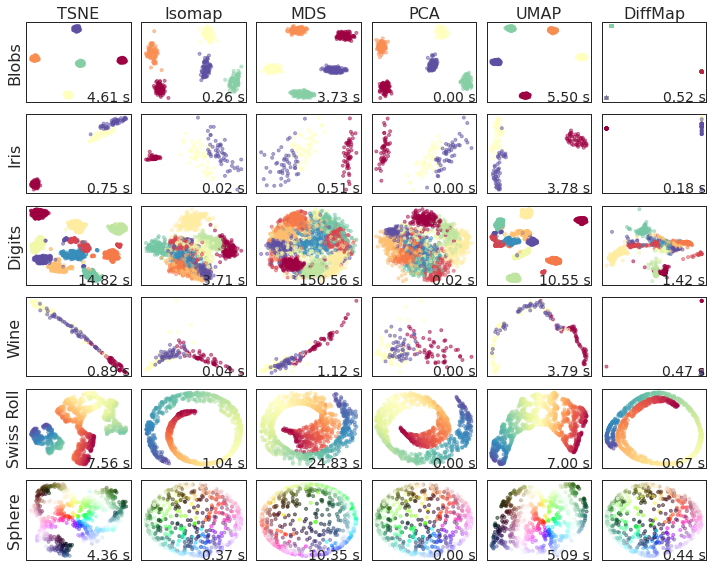

In [56]:
sns.set(context="paper", style="white")

blobs, blob_labels = datasets.make_blobs(
    n_samples=500, n_features=10, centers=5, random_state=42
)
iris = datasets.load_iris()
digits = datasets.load_digits(n_class=10)
wine = datasets.load_wine()
swissroll, swissroll_labels = datasets.make_swiss_roll(
    n_samples=1000, noise=0.1, random_state=42
)
sphere = np.random.normal(size=(600, 3))
sphere = preprocessing.normalize(sphere)
sphere_hsv = np.array(
    [
        (
            (np.arctan2(c[1], c[0]) + np.pi) / (2 * np.pi),
            np.abs(c[2]),
            min((c[2] + 1.1), 1.0),
        )
        for c in sphere
    ]
)
sphere_colors = np.array([hsv_to_rgb(*c) for c in sphere_hsv])

reducers = [
    (manifold.TSNE, { 'n_components':2, "perplexity": 50}),
    #(manifold.LocallyLinearEmbedding, {'n_neighbors':10, 'method':'hessian'}),
    (manifold.Isomap, { 'n_components':2, "n_neighbors": 30}), # Automatically select the shortest path algo
    (manifold.MDS, {'n_components':2}), # non metric MDS
    (decomposition.PCA, {'n_components':2}),
    (umap.UMAP, {'n_components':2,"n_neighbors": 30, "min_dist": 0.3}),
    (dm.DiffusionMap.from_sklearn,{'n_evecs':2, 'k': 200, 'epsilon': 'bgh_generous', 'alpha': 1.0, 'neighbor_params':{'n_jobs': -1, 'algorithm': 'ball_tree'}}),
]

test_data = [
    (blobs, blob_labels),
    (iris.data, iris.target),
    (digits.data, digits.target),
    (wine.data, wine.target),
    (swissroll, swissroll_labels),
    (sphere, sphere_colors),
]
dataset_names = ["Blobs", "Iris", "Digits", "Wine", "Swiss Roll", "Sphere"]

n_rows = len(test_data)
n_cols = len(reducers)
ax_index = 1
ax_list = []

# plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.figure(figsize=(10, 8))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)
for data, labels in test_data:
    for reducer, args in reducers:
        start_time = time.time()
        embedding = reducer(**args).fit_transform(data)
        elapsed_time = time.time() - start_time
        ax = plt.subplot(n_rows, n_cols, ax_index)
        if isinstance(labels[0], tuple):
            ax.scatter(*embedding.T, s=10, c=labels, alpha=0.5)
        else:
            ax.scatter(*embedding.T, s=10, c=labels, cmap="Spectral", alpha=0.5)
        ax.text(
            0.99,
            0.01,
            "{:.2f} s".format(elapsed_time),
            transform=ax.transAxes,
            size=14,
            horizontalalignment="right",
        )
        ax_list.append(ax)
        ax_index += 1
plt.setp(ax_list, xticks=[], yticks=[])

names = ['TSNE','Isomap','MDS','PCA','UMAP','DiffMap']

for i in np.arange(n_rows) * n_cols:
    ax_list[i].set_ylabel(dataset_names[i // n_cols], size=16)
for i in range(n_cols):
    ax_list[i].set_xlabel(names[i], size=16)
    ax_list[i].xaxis.set_label_position("top")

plt.tight_layout()
plt.show()